#### Física de la Radioterapia. Master de Física Biomédica. Universidad Complutense de Madrid
# Calibración del acelerador lineal
## Haces de fotones medidos en condiciones de referencia
-----

**Objetivos**: 
Determinar la dosis absorbida producida por un campo de radiación en condiciones estándar de calibración utilizando una cámara de ionización tipo Farmer y aplicando el [protocolo de dosimetría de la IAEA TRS398](https://www-pub.iaea.org/MTCD/publications/PDF/TRS_398s_Web.pdf). Se recomienda leer al menos el epígrafe **3. FORMALISMO BASADO EN** $N_{D,w}$ del protocolo.

**Antecendentes**: De acuerdo al TRS398 la magnitud $D_{w, Q}$, dosis en agua para la calidad de la radiación $Q$, se puede determinar mediante la expresión

\begin{equation}
    D_{w, Q} = M_Q\;N_{D, w, Q_0}\;k_{Q, Q_0}\;k_{sat}\;k_{pol}.
\end{equation}

donde:
- $M_Q$ es la lectura neta del electrómetro expresado en condiciones normales
- $N_{D, w, Q_0}$ es el valor del factor de calibración de la cámara en condiciones de referencia
- $k_{Q, Q_0}$ es el factor de corrección por la calidad del haz del factor de calibración
- $k_{sat}$ es el factor de corrección por saturación de la cámara
- $k_{pol}$ es factor de corrección por dependencia de la lectura de la cámara con la polarización de sus electrodos

**Datos**:
Los datos de la cámara empleada están recogidos en su [certificado de calibración](../docs/CamaraFarmer10820.pdf)

Previamente se ha determinado que para esta cámara los factores de corrección por saturación $k_{sat}$ y por polarización $k_{pol}$ son ambos igual a uno en las condiciones de medida consideradas.

La energía del haz empleado corresponde a una razón TPR${}_{20, 10} = 0.694$.

Para recolectar la carga producida en la cámara se utiliza un electrómetro con una resolución de $0.001$ nC.

## Cuestión
1. Obtener de los datos del TRS398 el factor de corrección de la calibración de la cámara por la energía para el haz utilizado.

**Ayuda**: Consultar el CUADRO 14 página 85.

Como en el certificado de calibración de la cámara la calidad del haz de referencia corresponde al ${}^{60}$Co, según el protocolo TRS398 podemos denotar el factor de corrección de la calibración por la energía $k_{Q, Q_0}$ como $k_Q$.
        
El $k_Q$ se obtiene interpolando en la tabla correspondiente al modelo de cámara PTW 30013, página 85 CUADRO 14, usando el valor dado para el TPR${}_{20,10}$.
        

| TPR${}_{20,10}$ | $k_Q$ |
|-----------------|-------|
|  0.700  | 0.988 |
|  0.680  | 0.990 |
| **0.694**|**0.9886**|


## Módulo `simcaliblinac`
Este cuaderno simula las condiciones variables de la medida mediante generadores aleatorios que siguen distribuciones realistas. Para realizar el ejercicio cada alumno generará y recogerá tanto las medidas como las condiciones en las que las ha realizado.

El módulo `simcaliblinac` contiene las funciones para realizar esta simulación.

En la siguiente celda importamos el módulo

In [1]:
import simcaliblinac as scl

Tomar los valores de la presión atmosférica indicada por el barómetro del Servicio y de la temperatura medida por la sonda del termómetro que introducimos en el agua. 

Las unidades de las medidas son presión en hPa y temperatura en grados centígrados.

In [2]:
presion, temperatura = scl.presion_temperatura_medida()
presion, temperatura

(array([946.1]), array([17.6]))

El módulo `simcaliblinac` ofrece una función para calcular la corrección por presión y temperatura $\phi$pT

In [3]:
ϕpT = scl.ϕpTf(presion, temperatura)
ϕpT

array([1.06194849])

Una vez montados los equipos, fijadas las condiciones experimentales y con todas las conexiones realizadas, comenzamos por medir la lecutra del electrómetro cuando no hay radiación. En Radioterapia a este valor lo denominamos *corriente de fugas*. Es el equivalente a una lectura de un valor de fondo pero de origen diferente.

Las fugas son de naturaleza aleatoria. Su valor medio se estima integrando durante un tiempo dado suficientemente largo como para promediar variaciones instantáneas. 

El módulo `simcaliblinac` expone un método para obtener una muestra de las fugas recolectadas durante un tiempo dado

In [4]:
fugas = scl.fugas(minutos=2)
fugas # en nanoCulombios

array([[0.157]])

Para hacer las medidas en el acelerador tenemos que fijar un número de unidades monitor nominales.

In [5]:
UM_nominales = 200

El módulo `simcaliblinac` expone un método para obtener una muestra de **n** medidas con las unidades monitor fijadas. Usualmente se toma una muestra de tamaño tres, porque es la menor muestra que permite tomar una decisión sobre la coherencia de las medidas. Tres medidas permiten asegurar que no ha ocurrido nada anómalo al tomar los datos si ningún valor discrepa mucho de los otros dos.

In [6]:
lecturas = scl.lectura_medida_f(UM=UM_nominales, n=3)
lecturas # en nanoCulombios

array([[35.578, 35.618, 35.619]])

Para calibrar el acelerador expresamos la medida de dosis en términos relativos a las unidades monitor, es decir, queremos saber cuánta dosis damos por unidad monitor. Por una decisión complemtamente arbitraria se suele ajustar la calibración para que en condiciones estándar una UM coincida con un centiGray. Este ajuste se realiza variando la ganancia de la cámaras monitoras. El cambio de la ganancia permite variar la lectura de la cámara aún recibiendo la misma dosis.

## Cuestiones
2. Determinar la dosis absorbida suministrada por el acelerador y el output.
1. Hacer una estimación de la incertidumbre en la medida de la dosis absorbida y en la medida del output

Para generar la respuesta hemos incluido en el módulo `simcalblinac` una función que calcula la dosis para las lecturas en el electrómetro, las condiciones de medida y los parámetros de la cámara.

In [7]:
dosis_medidas = scl.dosis_f(lecturas, UM=UM_nominales, ϕpT=ϕpT, fugas=fugas)
dosis_medidas

array([[2.01251087, 2.01477685, 2.0148335 ]])

Para hacer la estimación de las incertidumbres de la dosis tenemos que calcular primero la desviación estándar de la distribución de medias muestrales

In [8]:
import numpy as np

In [9]:
sigma_media_lecturas = np.round(lecturas.std(ddof=1)/np.sqrt(3), decimals=scl._resolucion_electrometro)
sigma_media_lecturas

0.014

Expresada en terminos relativos

In [11]:
sigma_relativa_media_lecturas = sigma_media_lecturas / lecturas.mean()
sigma_relativa_media_lecturas

0.0003932032017975004

Inferior al uno por mil, que es una incertidumbre ridículamente pequeña. Esto es porque solo hemos tenido en cuenta la repetibilidad del acelerador.

En la incertidumbre de la medida de la dosis tenemos que combinar las incertidumbres siguientes:

- Fugas: si solo tenemos una medida la estimamos con la resolución del electrómetro. $\sigma_{\text{fugas}}=\pm 0.001$
- Temperatura: si solo tenemos una medida la estimamos con la resolución del termómetro. $\sigma_{\text{temperatura}}=\pm 0.1$
- Presión: si solo tenemos una medida la estimamos con la resolución del barómetro. $\sigma_{\text{barometro}}=\pm 0.1$
- Incertidumbre del certificado de calibración: $\sigma_{N_{D, w, Q_0}}=\pm0.55\%$ (k=1), fijémonos que la incertidumbre del certificado está dada con factor de cobertura k=2.
- Incertidumbre de lectura: es la combinación de la resolución del electrómetro y la incertidumbre estadística de la lectura que la estimamos por la desviación estándar de la distribución de medias muestrales.

\begin{equation}
I_{\text{Lectura}}^2 = 0.001^2+\sigma_{\text{Media Lectura}}^2
\end{equation}

Para calcular las incertidumbres, combinarlas y propagarlas nos podemos ayudar con el módulo `uncertainties`

In [12]:
from uncertainties import ufloat, unumpy

In [13]:
# Magnitudes con incertidumbres
presion_unc = ufloat(presion, 10**-scl._resolucion_barometro)
temperatura_unc = ufloat(temperatura, 10**-scl._resolucion_termometro)
fugas_unc = ufloat(fugas, 10**-scl._resolucion_electrometro)
ϕpT_unc = scl.ϕpTf(p=presion_unc, T=temperatura_unc)
NDwQ0_unc = ufloat(scl._NDwQ0, scl._NDwQ0*scl._rel_unc_NDwQ0)
lectura_media_unc=ufloat(lecturas.mean(), 
                         np.sqrt(10**-scl._resolucion_electrometro**2 +
                                 sigma_media_lecturas**2))

# Dosis con incertidumbres
dosis_unc = scl.dosis_f(lecturas=lectura_media_unc,
                        UM=UM_nominales, 
                        ϕpT=ϕpT_unc, 
                        fugas=fugas_unc,
                        NDwQ0=NDwQ0_unc)
dosis_unc

2.014040402191485+/-0.011129197442249498

El cálculo de la incertidumbre del output es el mismo salvo que no incluye la incertidumbre del certificado de calibración. Estamos en condiciones de repetibilidad no de reproducibilidad, nos estamos comparando con nosotros mismos. En la determinación de la variación del output comparamos una calibración previa con otra posterior y en amabas hemos utilizado el mismo certificado de calibración.

In [14]:
output_unc = scl.output_f(lecturas=lectura_media_unc, 
                          UM=UM_nominales, 
                          ϕpT=ϕpT_unc, 
                          fugas=fugas_unc) 
output_unc

1.0070202010957425+/-0.000537164726450061

In [21]:
output_unc_short = scl.output_f(lecturas=lectura_media_unc, 
                                UM=UM_nominales,
                                ϕpT=ϕpT, 
                                fugas=fugas) 
output_unc_short

array([[1.010271180923502+/-0.0005102912566675325]], dtype=object)

## Comprobaciones y simulaciones estadísticas

Internamente el módulo `simcaliblinac` nos permite saber cuál es el valor esperado actual de la lectura, el valor que hubiéramos obtenido de haber realizado la medida infitas veces en las mismas condiciones y sin incertidumbres en la medida de todas las variables.

In [15]:
scl._lectura_actual_f(UM=UM_nominales)

35.642

El módulo `simcaliblinac` expone métodos para calcular la dosis para el número de unidades monitor fijado. Si hemos extraído correctamente la información del TRS398 las dosis que hemos calculado en las cuestiones anteriores deberían coincidir, salvo errores de redondeo, con las dosis calculadas por estas funciones.

Al ejecutar la siguiente celda obtenemos las dosis medidas calculadas mediante el módulo `simcaliblinac`

In [16]:
D_meds = scl.dosis_f(lecturas, UM=UM_nominales, ϕpT=ϕpT, fugas=fugas/2)
D_meds

array([[2.01399319, 2.01625917, 2.01631582]])

El módulo `simcaliblinac` expone también métodos para calcular el output del acelerador (dosis en Gy por cada 100 UM)

Output medidos

In [17]:
output_meds = scl.output_f(lecturas, UM=UM_nominales, ϕpT=ϕpT, fugas=fugas/2)
output_meds

array([[1.0069966 , 1.00812959, 1.00815791]])

Como estas funciones devuelven sus valores de dosis y output en objetos de tipo array podemos hacer facilmente estadísticas: media y desviación estándar.

In [18]:
D_meds.mean(), D_meds.std(), output_meds.mean(), output_meds.std()

(2.0155227304891468,
 0.0010817926614304955,
 1.0077613652445734,
 0.0005408963307152477)

En el Servicio de Radioterapia en el que estamos realizando estas medidas se tiene el criterio de recalibrar el acelerador, ajustar de nuevo las ganancias de las cámaras, si la variación del output respecto al valor nominal de 1 es mayor del 1.5%.

En la teoría del control de calidad se distinguen dos conceptos: *tolerancia* e *incertidumbre*.
- **Tolerancia**: Rango de la variable de control que daría lugar a resultados aceptables. Por ejemplo se consideran tolerables variaciones en la dosis final que reciben los pacientes inferiores al 5% porque no ha sido posible detectar diferencias clínicas en los resultados de tratamientos realizados con esas variaciones.

- **Incertidumbre**: Rango en el que se espera se encuentre el valor *real* de una magnitud medida.

En general se requiere que la variable de control se mida con una incertidumbre inferior a la tolerancia, idealmente incluso despreciable.

El tratamiento combinado de  la tolerancia y la incertidumbre lleva al concepto de *nivel de acción*, como el umbral para el resultado del control que indica la necesidad de realizar alguna corrección.

Dependiendo cuánto de crítico sea el resultado de nuestro control se definen dos posibles formas de situar el nivel de acción:
- **Nivel de acción mayor que la tolerancia**: Se aumenta la tolerancia con la incertidumbre. Expandimos la tolerancia porque aceptamos que los resultados puedan salirse de tolerancia si hay una cierta probabilidad de que estén dentro de tolerancia por su incertidumbre. Por ejemplo si los radares de la DGT miden la velocidad con una incertidumbre del 4% (k=3) solo nos multan si miden que nuestra velocidad supera el límite señalado en más de un 4%. En un tramo a  120 km/h multan si miden más de 124.8 km/h porque de esa manera el 99% de los multados realmente iban a más de 120. Solo hay un 1% de probabilidad de recibir una multa injusta.
- **Nivel de acción inferior la tolerancia**: Se reduce la tolerancia con la incertidumbre. Disminuimos la tolerancia porque no aceptamos los resultados que aunque se encuentren dentro de tolerancia tienen una cierta probabilidad de indicar un resultado fuera de tolerancia si se considera su incertidumbre. Por ejemplo si lo que medimos es la resistencia de una viga no podemos permitir medidas dudosas, aquí lo que hacemos es rechazar *de más*, queremos reducir la probabilidad de *falsos aceptados*.

## Cuestiones
4. Sabiendo que en el Servicio de Radioterapia considerado se ha tomado el criterio de definir el nivel de acción mayor que la tolerancia responder razonadamente si es necesario ajustar las ganancias o no a la vista de los resultados obtenidos.

*Nota*: En esta cuestión se valorará positivamente que cada alumno compare sus resultados con otros compañeros de clase (idealmente con todos) y que discutan qué decisión toman sobre las ganancias.

5. Comparar las desviaciones estándar de nuestras medidas con la estimación de incertidumbres realizada en la cuestión 3. Si son diferentes comentar cómo se justifican esas diferencias.

### Simulaciones

#### Teorema del límite central
Las funciones del módulo `simcaliblinac` están preparadas para cambiar el tamaño de la muestra de medidas y repetir la toma de muestras tantas veces como queramos. El tamaño de la muestra se indica pasando el parámetro **n** y el número de experimentos pasando el parámetro **trials**.

Ejecutando la siguiente celda obtenemos treinta muestras diferentes de cinco medidas cada una cuando fijamos 200 UM y lo almacenamos en el array de numpy muestras. Como resultado de la celda mostramos las dimensiones del array.

In [21]:
sample_size=5
trial_number=30
muestras = scl.lectura_medida_f(UM=UM_nominales, n=sample_size, trials=trial_number)
muestras.shape

(30, 5)

Si queremos mostrar el contenido de muestras ejecutamos esta celda

In [22]:
muestras

array([[35.617, 35.685, 35.66 , 35.654, 35.677],
       [35.587, 35.702, 35.653, 35.659, 35.657],
       [35.647, 35.635, 35.66 , 35.628, 35.68 ],
       [35.59 , 35.659, 35.604, 35.631, 35.608],
       [35.664, 35.678, 35.646, 35.632, 35.691],
       [35.647, 35.595, 35.604, 35.595, 35.646],
       [35.593, 35.682, 35.683, 35.632, 35.671],
       [35.667, 35.656, 35.609, 35.676, 35.637],
       [35.634, 35.618, 35.604, 35.619, 35.594],
       [35.634, 35.638, 35.707, 35.604, 35.666],
       [35.635, 35.65 , 35.672, 35.636, 35.583],
       [35.686, 35.62 , 35.7  , 35.62 , 35.611],
       [35.649, 35.617, 35.658, 35.688, 35.601],
       [35.638, 35.635, 35.614, 35.696, 35.645],
       [35.71 , 35.704, 35.641, 35.598, 35.682],
       [35.673, 35.671, 35.682, 35.698, 35.618],
       [35.639, 35.608, 35.655, 35.649, 35.662],
       [35.614, 35.695, 35.636, 35.626, 35.629],
       [35.655, 35.686, 35.629, 35.614, 35.698],
       [35.567, 35.639, 35.671, 35.674, 35.641],
       [35.697, 35.6

Podemos calcular estádisticas del total de la muestra

In [23]:
muestras.mean(), muestras.std()

(35.642579999999995, 0.03618052330559489)

Podemos construir una colección con las medias y desviaciones estándar de cada experimento

In [24]:
muestras_distribucion_medias = muestras.mean(axis=1) 
muestras_distribucion_sigmas = muestras.std(axis=1, ddof=1)

# Mostrar las muestras de ambas ditribuciones
muestras_distribucion_medias, muestras_distribucion_sigmas

(array([35.6586, 35.6516, 35.65  , 35.6184, 35.6622, 35.6174, 35.6522,
        35.649 , 35.6138, 35.6498, 35.6352, 35.6474, 35.6426, 35.6456,
        35.667 , 35.6684, 35.6426, 35.64  , 35.6564, 35.6384, 35.6124,
        35.5938, 35.6328, 35.6514, 35.666 , 35.6214, 35.6588, 35.6212,
        35.6434, 35.6696]),
 array([0.02640644, 0.04122863, 0.02072438, 0.02706104, 0.02375289,
        0.02681977, 0.03906021, 0.02667396, 0.01533623, 0.03879691,
        0.03278262, 0.04208087, 0.03437005, 0.0304516 , 0.04711688,
        0.03012142, 0.02110213, 0.03175689, 0.03590682, 0.0431138 ,
        0.05915911, 0.03829752, 0.03106767, 0.05300283, 0.02176006,
        0.0211731 , 0.0432747 , 0.04325159, 0.01844722, 0.02700555]))

## Cuestión
6. Mostrar numéricamente que se verifica el teorema del límite central, es decir, que la media de las muestras de la distribución de medias es la misma que la media de todas las medidas y que dentro de incertidumbres muestrales el valor esperado de la distrubución de sigmas es la sigma de la distrubución total dividida por la raíz cuadrada del tamaño de la muestra

In [25]:
muestras_distribucion_medias.mean() / muestras.mean()

1.0

In [26]:
muestras_distribucion_medias.std(ddof=1) / muestras.std(ddof=1) * np.sqrt(sample_size)

1.1713786414951168

## Cuestiones

7. Hacer una gráfica de la razón entre la media de la distrubución de sigmas y la sigma de la distrubución total en función del número de experimientos. Discutir si tiene un comportamiento asintótico y en su caso indicar a qué valor tiende.

**Sugerencia**: Juntar el código mostrado en las celdas anteriores para definir una función dependiente del número de experimentos que devuelva razón entre la media de la distrubución de sigmas y la sigma de la distrubución total. Generar un rango de número de experimentos, pasárselo a la función y hacer la gráfica.

8. Hacer una gráfica de la razón entre la media de la distrubución de sigmas y la sigma de la distrubución total en función del tamaño de la muestra. Analizar la importancia del parametro `ddof` para evitar el sesgo por el tamaño de la muestra. Ver la documentación de numpy

**Sugerencia**: Juntar el código mostrado en las celdas anteriores para definir una función dependiente del tamaño de la muestra que devuelva la diferencia relativa 

In [27]:
import matplotlib.pyplot as plt

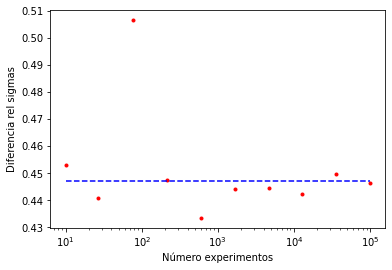

In [28]:
def sigmas_f_numero_experimentos(trials):
    muestras = scl.lectura_medida_f(UM=UM_nominales, n=sample_size, trials=trials)
    muestras_distribucion_medias = muestras.mean(axis=1)
    diferencia_relativa_numero_experimentos = muestras_distribucion_medias.std() / muestras.std()
    return diferencia_relativa_numero_experimentos

trial_number_list = np.geomspace(1e1, 1e5, 10, dtype=int)
diferencia_relativa_numero_experimentos_list =  [sigmas_f_numero_experimentos(trial_number) for trial_number in trial_number_list]
fig, ax = plt.subplots()
ax.plot(trial_number_list, diferencia_relativa_numero_experimentos_list, 'r.')
ax.plot([1e1, 1e5], [np.sqrt(sample_size)**-1,np.sqrt(sample_size)**-1], 'b--')
ax.set_xscale('log')
ax.set_xlabel('Número experimentos')
ax.set_ylabel('Diferencia rel sigmas')
plt.show()

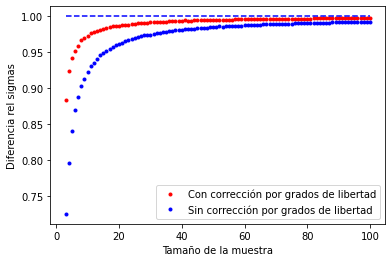

In [37]:
def sigmas_f_sample_size(n):
    muestras = scl.lectura_medida_f(UM=UM_nominales, n=n, trials=int(1e4))
    muestras_distribucion_sigmas = muestras.std(axis=1, ddof=1)
    muestras_distribucion_sesgada_sigmas = muestras.std(axis=1)
    razon_sample_size = muestras_distribucion_sigmas.mean() / muestras.std()
    razon_sesgada_sample_size = muestras_distribucion_sesgada_sigmas.mean() / muestras.std()
    return razon_sample_size, razon_sesgada_sample_size

sample_size_list = np.linspace(3, 100, 98, dtype=int)
razon_sample_size_list =  [sigmas_f_sample_size(n)[0] for n in sample_size_list]
razon_sesgada_sample_size_list =  [sigmas_f_sample_size(n)[1] for n in sample_size_list]
fig, ax = plt.subplots()
ax.plot(sample_size_list, razon_sample_size_list, 'r.', label='Con corrección por grados de libertad')
ax.plot(sample_size_list, razon_sesgada_sample_size_list, 'b.', label='Sin corrección por grados de libertad')
ax.plot([3, 100], [1, 1], 'b--')
ax.set_xlabel('Tamaño de la muestra')
ax.set_ylabel('Diferencia rel sigmas')
ax.legend()
plt.show()

In [38]:
numero_trials=50

In [39]:
muestras_lecturas = scl.lectura_medida_f(UM=UM_nominales, n=3, trials=numero_trials)
muestras_presion, muestras_temperatura = scl.presion_temperatura_medida(trials=numero_trials)
muestras_ϕpT = scl.ϕpTf(muestras_presion, muestras_temperatura)
muestras_fugas = scl.fugas(trials=numero_trials)

In [40]:
muestras_outputs = scl.output_f(lecturas=muestras_lecturas.mean(axis=1),
                                UM=UM_nominales,
                                ϕpT=muestras_ϕpT,
                                fugas=muestras_fugas)

In [41]:
outputs_unc = ufloat(muestras_outputs.mean(), muestras_outputs.std())
outputs_unc

1.0127402675675838+/-0.0030682401109176746